---
# Wine Quality "Warm up" Challenge
### Physicochemical factors that predict good quality wine
---
The "warm up" challenge for this year is adapted from the well-known 'Wine Quality' challenge on Kaggle. In particular, given a dataset containing several attributes describing wine, your task is to make predictions on the quality of as-yet unlisted wine samples. Developing a model which accurately fits the available training data while also generalising to unseen data-points is a multi-faceted challenge that involves a mixture of data exploration, pre-processing, model selection, and performance evaluation.

**IMPORTANT**: please refer to the AML course guidelines concerning grading rules. Pay especially attention to the **presentation quality** item, which boils down to: don't dump a zillion of lines of code and plots in this notebook. Produce a concise summary of your findings: this notebook can exist in two versions, a "scratch" version that you will use to work and debug, a "presentation" version that you will submit. The "presentation" notebook should go to the point, and convay the main findings of your work.

---
## Overview
Beyond simply producing a well-performing model for making predictions, in this challenge we would like you to start developing your skills as a machine learning scientist. In this regard, your notebook should be structured in such a way as to explore the following tasks, that are expected to be carried out whenever undertaking such a project. The description below each aspect should serve as a guide for your work, but you are can also explore alternative options and directions. Thinking outside the box will be rewarded in these challenges.

### 1. Data preparation:
   
_Data exploration_: The first broad component of your work should enable you to familiarise yourselves with the given data, an outline of which is given at the end of this challenge specification. Among others, you can work on:
   
* Data cleaning, e.g. treatment of categorial variables;
* Data visualisation; Computing descriptive statistics, e.g. correlation.

_Data Pre-processing_: The previous step should give you a better understanding of which pre-processing is required for the data. This may include:

* Normalising and standardising the given data;
* Removing outliers;
* Carrying out feature selection, possibly using metrics derived from information theory;
* Handling missing information in the dataset;
* Augmenting the dataset with external information;
* Combining existing features.

Note that, as the name implies, this is a warm-up challenge, which essentially means that data is already put in a convenient format that requires minimal pre-processing.

### 2. Model selection
An important part of the work involves the selection of a model that can successfully handle the given data and yield sensible predictions. Instead of focusing exclusively on your final chosen model, it is also important to share your thought process in this notebook by additionally describing alternative candidate models. There is a wealth of models to choose from, such as decision trees, random forests, (Bayesian) neural networks, Gaussian processes, LASSO regression, and so on. 

Irrespective of your choice, it is highly likely that your model will have one or more parameters that require tuning. There are several techniques for carrying out such a procedure, such as cross-validation.

### 3. Performance evaluation
The evaluation metric for this project is "Log Loss". For the N wines in the test data set, the metric is calculated as:

\\(\mathcal{L} = \frac{1}{N} \sum_{i=1}^{N} y_i p_i + (1-y_i) \log(1-p_i)\\)

where \\(y\\) is the true (but withheld) quality outcome for wine \\(i\\) in the test data set, and \\(p\\) is the predicted probability of good quality for wine \\(i\\). Larger values of \\(\mathcal{L}\\) indicate poorer predictions.

---
## Dataset description
You will be working on two data files, which will be available in ```/mnt/datasets/wine/```, one for red and one for white wines:

* winequality-red.csv 
* winequality-white.csv

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult the reference Cortez et al., 2009. Only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

### Tips
A possible trick is to set an arbitrary cutoff for your dependent variable (wine quality) at e.g. 7 or higher getting classified as 'good/1' and the remainder as 'not good/0'. Note that this can be seen as a data preparation task.

### Training and test sets
We leave to the students to decide how to carve out training and test sets (validation sets too, if relevant to your approach). This is non a competition whereby the instructors hold a "private" test set to rank students' models.



P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties.
In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

### Attributes

Input variables (based on physicochemical tests):
1 - fixed acidity
2 - volatile acidity
3 - citric acid
4 - residual sugar
5 - chlorides
6 - free sulfur dioxide
7 - total sulfur dioxide
8 - density
9 - pH
10 - sulphates
11 - alcohol
Output variable (based on sensory data):
12 - quality (score between 0 and 10)

### 1. Data preparation:

In [85]:
# Importations
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Cross val, gridsearch and scores 
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import log_loss, make_scorer, accuracy_score

from sklearn.model_selection import cross_val_score
warnings.filterwarnings("ignore")
SEED = 77

### 1.1 Data cleaning:

In [36]:
dataset_r = pd.read_csv('winequality-red.csv', sep=';')
dataset_w = pd.read_csv('winequality-white.csv', sep=';')
print('Red wine data set: ', dataset_r.shape)
print('White wine data set: ', dataset_w.shape)

Red wine data set:  (1599, 12)
White wine data set:  (4898, 12)


<div class='alert alert-block alert-info'>
The two dataset do not have the same number of samples. <b>The 'important' features are not necessary the same for white and red wine.</b>
</div>

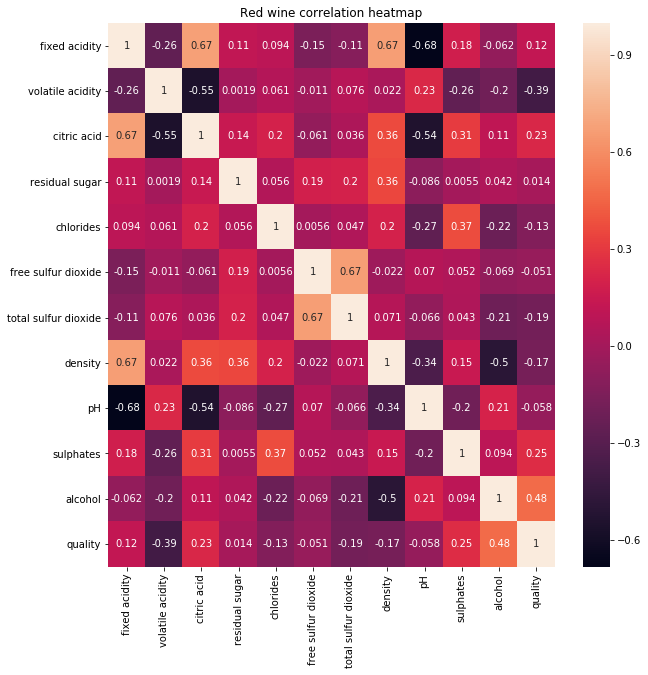

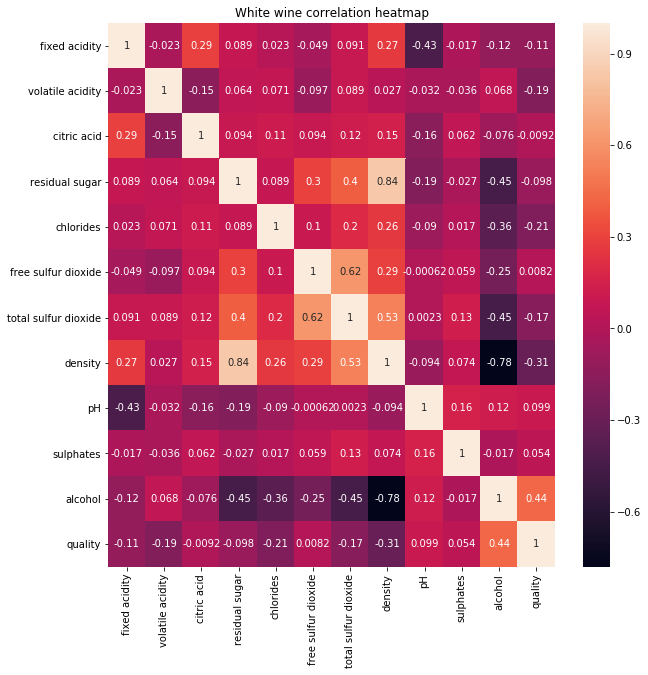

In [37]:
fig, ax = plt.subplots(figsize=(10,10))
sn.heatmap(dataset_r.corr(), annot=True, ax=ax)
plt.title('Red wine correlation heatmap')
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
sn.heatmap(dataset_w.corr(), annot=True, ax=ax)
plt.title('White wine correlation heatmap')
plt.show()

<div class='alert alert-block alert-info'>
The correlation matrixes of the two datasets do not highlight the same feature importance between red and white wine.
<br />
For red wine the important features that correlate with quality are:
    <ul>
        <li> alcohol </li>
        <li> sulphates </li>
        <li> volatile acidity </li>
    </ul>
    
<br />
For white wine the important features that correlate with quality are:
    <ul>
        <li> alcohol </li>
        <li> density </li>
        <li> chloride </li>
    </ul>

<div class='label label-primary'> 
    As they are not a lot of different features, it seems for us that there is no need to remove features that are highly correlated to prevent time-consuming computation.
</div>
</div>

### 1.2  Data Pre-processing

<div class='alert alert-block alert-info'>
We transform the problem into a <b>binary classification problem</b>. Every wine with quality > 7 will be classified as "Good" the other will be classified as "Not so good".
</div>

In [38]:
# Binary classification problem
dataset_r.quality.loc[ (dataset_r.quality < 7)] = 0
dataset_w.quality.loc[ (dataset_w.quality < 7)] = 0

dataset_r.quality.loc[ (dataset_r.quality >= 7) ] = 1
dataset_w.quality.loc[ (dataset_w.quality >= 7) ] = 1

<div class='alert alert-block alert-info'>

Now we create a new categorical feature type = 0(Red) or 1(White), then concat the datasets.    

</div>

In [42]:
# Create new feature for the type

dataset_r['type'] = 0
dataset_w['type'] = 1

# Concat 
dataset = pd.concat([dataset_r, dataset_w], axis = 0)



<div class='alert alert-block alert-info'>

We check if they are no missing values

</div>

In [43]:
# No missing values
(dataset.isnull()*1).sum()

fixed acidity           0.0
volatile acidity        0.0
citric acid             0.0
residual sugar          0.0
chlorides               0.0
free sulfur dioxide     0.0
total sulfur dioxide    0.0
density                 0.0
pH                      0.0
sulphates               0.0
alcohol                 0.0
quality                 0.0
type                    0.0
dtype: float64

In [44]:
dataset.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,0


<div class='alert alert-block alert-info'>
We split our data into target and input for our algorithms
</div>

In [52]:
y = dataset.quality.values
X = dataset.drop('quality', axis = 1).values

<div class='alert alert-block alert-info'>
Standardisation the data in order to scale everything for our models. 
</div>

In [53]:
scale = StandardScaler().fit(X)
    
# transform the training data column
X_stand = scale.transform(X)

<div class='alert alert-block alert-info'>
We split our data into training and testing dataset. 
We take 20% for the testing and 80% for the training.
</div>

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_stand,y,test_size=0.2,random_state=SEED)


## 2. Model selection and performance

In [55]:
dataset.quality.value_counts()

0    5220
1    1277
Name: quality, dtype: int64

<div class='alert alert-block alert-info'>
    <b>Classes are unbalanced</b>. A Dummy classifier (always predicting class 0) would be our baseline with accuracy: <b>5220/6497 = 80%</b>
</div>

<div class='alert alert-block alert-info'>
We will try to evaluate different models:
    <ul>
        <li> Logistic regression </li>
        <li> SVC </li>
        <li> KNN </li>
        <li> Random forest </li>
    </ul>
We will use cross validation to avoid overfitting
    
    
We'll use either <b>log loss</b> and <b> accuracy </b> to evaluate our models.
</div>

### 2.1. Logistic regression

In [81]:
log_clf = LogisticRegression(solver='lbfgs')
log_score = cross_validate(log_clf, X, y, scoring={'acc': accuracy_scorer, 'logloss': logloss_scorer}, cv=5)

print("Accuracy:", log_score['test_acc'].mean())
print("Log loss:  ", log_score['test_logloss'].mean())

Accuracy: 0.7975972049505536
Log loss:   6.9907810722723385


<div class='alert alert-block alert-info'>
Accuracy is not better than baseline, a good log loss is close to 0. <b>This model is not better than dummy.</b>    
</div>

### 2.2. SVM

In [82]:
svm_clf = LinearSVC(tol=1e-6, max_iter=10000)
svm_score = cross_validate(svm_clf, X, y, scoring={'acc': accuracy_scorer, 'logloss': logloss_scorer}, cv=5)

print("Log loss: ", svm_score['test_acc'].mean())
print("Accuracy: ", svm_score['test_logloss'].mean())

Log loss:  0.6927668620832593
Accuracy:  10.611616415223294


<div class='alert alert-block alert-info'>
Same problem : <b>This model is not better than dummy.</b>
    We can try to change the kernel, and tune the hyperparameters.
</div>

### 2.3. KNN

In [83]:
knn_clf = KNeighborsClassifier(n_neighbors=50)
knn_score = cross_validate(knn_clf, X, y, scoring={'acc': accuracy_scorer, 'logloss': logloss_scorer}, cv=5)

print("Log loss: ", knn_score['test_acc'].mean())
print("Accuracy: ", knn_score['test_logloss'].mean())

Log loss:  0.8014462012198733
Accuracy:  6.857813383476963


<div class='alert alert-block alert-info'>
The KNN model is slightly better than the baseline.
</div>

### 2.4. Random Forest

In [84]:
rf_clf = RandomForestClassifier(n_estimators=150, max_depth=20)
rf_score = cross_validate(rf_clf, X, y, scoring={'acc': accuracy_scorer, 'logloss': logloss_scorer}, cv=5)

print("Log loss: ", rf_score['test_acc'].mean())
print("Accuracy: ", rf_score['test_logloss'].mean())

Log loss:  0.8165298750518151
Accuracy:  6.33686501209249


<div class='alert alert-block alert-info'>
Our best model so far.
This model deserves some <b>hyper parameters tunning</b> to take the most out of it.
</div>

### 3. Hyper parameters tunning

In [87]:
rf_clf = RandomForestClassifier()

param = {
    'n_estimators': np.arange(100,500,50),
    'max_depth': [5, 10, 15, 20],
}

grid_rfc = GridSearchCV(rf_clf, param_grid=param, scoring=logloss_scorer, cv=5)
grid_rfc.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([100, 150, 200, 250, 300, 350, 400, 450]), 'max_depth': [5, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(log_loss), verbose=0)

In [88]:
grid_rfc.best_params_

{'max_depth': 5, 'n_estimators': 150}

In [90]:
rf_clf = RandomForestClassifier(n_estimators=150, max_depth=5)
rf_score = cross_validate(rf_clf, X, y, scoring={'acc': accuracy_scorer, 'logloss': logloss_scorer}, cv=5)

print("Log loss: ", rf_score['test_acc'].mean())
print("Accuracy: ", rf_score['test_logloss'].mean())

Log loss:  0.8162246698643927
Accuracy:  6.347394731815474


<div class='alert alert-block alert-info'>
This is our best score. 

    
This model is slighty higher than a dummy classifier. 

We can see that the high values of log loss bring uncertainty on the predictions.    
   
</div>

### Some thoughts:

https://machinelearningmastery.com/cross-validation-for-imbalanced-classification/

<div class='alert alert-block alert-info'>
Cross validation for unbalanced class problem is tricky and error prone because some fold can have few or no sample from some class leading to irrelevant score for the fold. We could have used a different method shown in the article above: <b>stratified KFold.</b>
</div>